# Pipeline générale
---
## I. Import des librairies
Import des librairies nécéssaires pour les scripts et l'import de dataset d'exemple.

In [1]:
# Librairies math
import pandas as pd
import numpy as np
import math

# Librairies computer vision (graphiques, images, vidéo)
# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Autres
import plotly.express as px
from skimpy import skim
import pywedge as pw

# Librairies Data-Science
# Scikit-learn
from sklearn.datasets import load_iris # Dataset d'exemple
from sklearn.model_selection import train_test_split # Séparation des données test et train
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer # Imputations simples
from sklearn.impute import KNNImputer # KNN Imputer
from sklearn.experimental import enable_iterative_imputer # Imputeur MICE
from sklearn.impute import IterativeImputer # Imputeur MICE
from sklearn.linear_model import LinearRegression # Imputation par régression
from sklearn.model_selection import train_test_split # Imputation par régression

# Autre
import itertools
from hyppo.independence import Hsic # Coefficient HSIC
import dcor # dCorr

# Style
import seaborn as sns

sns.set_style("darkgrid") # Style des graphes

Fonctions personnalisées :

In [2]:
import sys
sys.path.append('/home/alexis/VSCode/Jupyter-notebooks/BankModel/src')

import _regression_logistique as rlg

## II. Pré-traitement des données
### 1. Import des données
---
#### 1.1 Import d'un dataset built-in d'une librairie 
On peut prendre un dataset déjà présent dans une librairie, comme `iris` de la librairie `sklearn`. Ces datasets dit "sandbox" sont à but pédagogiques ou pour le prototypage, on peut en retrouver dans certaines librairies comme `sklearn` ou `seaborn`.

In [3]:
# Init
iris = load_iris() # Charge le dataset
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


On souhaite maintenant faire la différence entre les différentes espèces. On importe alors la colonne des espèces :

In [4]:
# Charge les espèces des iris et change le nom des colonnes dans le DataFrame 
df["species"] = iris.target
species_names = iris.target_names
df['species'] = df['species'].apply(lambda x: species_names[x])

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


#### 1.2 Import d'un fichier CSV / excel
On peut aussi prendre un dataset issu d'un fichier .csv ou excel. On prend le fichier "ozone_complet.csv" pour l'exemple. Attention ici à spécifier les séparateurs en mode anglosaxon (,) ou français (;) qui peuvent poser des problèmes d'import. De même pour les virgules des nombres flottants anglosaxons (.) et français (,).

1. On corrige le problème de séparateur grâce à la commande `sep` pour transformer l'interprétation du fichier.csv. On spécifie ";" pour transformer le mode anglosaxon en mode français par exemple.
2. On corrige le problème de décimales grâce à la commande `decimal`. Pour passer des décimales "anglosaxonnes" au format "français", on spécifie la valeur ",". 

In [5]:
df = pd.read_csv(
    'src/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

df.head()

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
date,,,,,,,,,,,,,,,,,,,,,
19950401,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,290.0,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2
19950402,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,160.0,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6
19950403,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,20.0,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2
19950404,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,10.0,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8
19950405,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,340.0,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8


#### 1.3 Import d'une image

#### 1.3 Import d'une vidéo

### 2 Analyse descriptive
---
#### 2.1 Les commandes de base

Dans cette section sont listées des méthodes et commandes qui permettent de faire une vue d'ensemble rapide sur le jeu de données brut. On prend ici pour l'exemple un dataset complet : celui du `Titanic`. L'avantage de ce dataset est qu'il comporte beaucoup de variables de différents types (float, booléen, classes), ce qui permet d'afficher les différentes manières d'aborder un dataset tout en restant très général.

In [6]:
df = sns.load_dataset("titanic") # Charge le dataset

1. Informations sur les variables (type, nom des colonnes, nombre de lignes non-nulles...):

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


2. Affiche les 5 premières lignes du dataset :

In [8]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


3. Affiche les 5 dernières lignes du dataset :

In [9]:
df.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
886,0,2,male,27.0,0,0,13.00,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.00,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.45,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.00,C,First,man,True,C,Cherbourg,yes,True
890,0,3,male,32.0,0,0,7.75,Q,Third,man,True,NaN,Queenstown,no,True


4. Description

In [10]:
df.describe().transpose().round(2) # Deux chiffres significatifs après la virgule

,count,mean,std,min,25%,50%,75%,max
survived,891.0,0.38,0.49,0.00,0.00,0.00,1.0,1.00
pclass,891.0,2.31,0.84,1.00,2.00,3.00,3.0,3.00
age,714.0,29.70,14.53,0.42,20.12,28.00,38.0,80.00
sibsp,891.0,0.52,1.10,0.00,0.00,0.00,1.0,8.00
parch,891.0,0.38,0.81,0.00,0.00,0.00,0.0,6.00
fare,891.0,32.20,49.69,0.00,7.91,14.45,31.0,512.33


<table style="width:100%; border-collapse: collapse; background-color: #e0f7f5; box-shadow: 0 2px 8px rgba(0, 128, 128, 0.1);">
  <thead>
    <tr style="background-color: #b2f0ec; color: #006666;">
      <th style="border:1px solid #91d8d4; padding:10px;">Statistique</th>
      <th style="border:1px solid #91d8d4; padding:10px;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr style="background-color:#f2fcfb;">
      <td style="border:1px solid #bce7e4; padding:10px;"><strong>count</strong></td>
      <td style="border:1px solid #bce7e4; padding:10px;">Nombre de valeurs non-nulles</td>
    </tr>
    <tr style="background-color: #ffffff;">
      <td style="border:1px solid #bce7e4; padding:10px;"><strong>mean</strong></td>
      <td style="border:1px solid #bce7e4; padding:10px;">Moyenne de la covariable</td>
    </tr>
    <tr style="background-color:#f2fcfb;">
      <td style="border:1px solid #bce7e4; padding:10px;"><strong>std</strong></td>
      <td style="border:1px solid #bce7e4; padding:10px;">Écart-type (standard deviation)</td>
    </tr>
    <tr style="background-color: #ffffff;">
      <td style="border:1px solid #bce7e4; padding:10px;"><strong>min</strong></td>
      <td style="border:1px solid #bce7e4; padding:10px;">Valeur minimale de la covariable</td>
    </tr>
    <tr style="background-color:#f2fcfb;">
      <td style="border:1px solid #bce7e4; padding:10px;"><strong>25%</strong></td>
      <td style="border:1px solid #bce7e4; padding:10px;">Premier quartile (1/4 des valeurs sont plus basses que le 1er quartile)</td>
    </tr>
    <tr style="background-color: #ffffff;">
      <td style="border:1px solid #bce7e4; padding:10px;"><strong>50%</strong></td>
      <td style="border:1px solid #bce7e4; padding:10px;">Deuxième quartile (1/2 des valeurs sont plus basses que le 2ème quartile)</td>
    </tr>
    <tr style="background-color:#f2fcfb;">
      <td style="border:1px solid #bce7e4; padding:10px;"><strong>75%</strong></td>
      <td style="border:1px solid #bce7e4; padding:10px;">Troisième quartile (3/4 des valeurs sont plus basses que le 3ème quartile)</td>
    </tr>
    <tr style="background-color: #ffffff;">
      <td style="border:1px solid #bce7e4; padding:10px;"><strong>max</strong></td>
      <td style="border:1px solid #bce7e4; padding:10px;">Valeur maximale de la covariable</td>
    </tr>
  </tbody>
</table>

5. On peut aussi avoir une vision assez élégante et rapide des informations générales du dataset grâce à la librairie `Skimpy`. Ce module est une alternative propre à `pandas.describe()`

In [11]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 891    │ │ string      │ 5     │ │ class                 │                                │
│ │ Number of columns │ 15     │ │ int64       │ 4     │ │ deck                  │                                │
│ └───────────────────┴────────┘ │ float64     │ 2     │ └───────────────────────┘                                │
│                                │ category    │ 2     │                                                          │
│                                │ bool        │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column    ┃ NA   ┃ NA %                 ┃ mean    ┃ sd      ┃ p0    ┃ p25   ┃ p50   ┃ p75 ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ survived  │    0 │                    0 │  0.3838 │  0.4866 │     0 │     0 │     0 │   1 │     1 │ █    ▅ │  │
│ │ pclass    │    0 │                    0 │   2.309 │  0.8361 │     1 │     2 │     3 │   3 │     3 │ ▄  ▃ █ │  │
│ │ age       │  177 │   19.865319865319865 │    29.7 │   14.53 │  0.42 │ 20.12 │    28 │  38 │    80 │ ▂██▃▁  │  │
│ │ sibsp     │    0 │                    0 │   0.523 │   1.103 │     0 │     0 │     0 │   1 │     8 │   █    │  │
│ │ parch     │    0 │                    0 │  0.3816 │  0.8061 │     0 │     0 │     0 │   0 │     6 │  █▁▁   │  │
│ │ fare      │    0 │                    0 │    32.2 │   49.69 │     0 │  7.91 │ 14.45 │  31 │ 512.3 │   █    │  │
│ └───────────┴──────┴──────────────────────┴─────────┴─────────┴───────┴───────┴───────┴─────┴───────┴────────┘  │
│                                                    category                                                     │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓  │
│ ┃ column          ┃ NA        ┃ NA %                                    ┃ ordered           ┃ unique         ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩  │
│ │ class           │         0 │                                       0 │ False             │              3 │  │
│ │ deck            │       688 │                       77.21661054994388 │ False             │              8 │  │
│ └─────────────────┴───────────┴─────────────────────────────────────────┴───────────────────┴────────────────┘  │
│                                                      bool                                                       │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column                            ┃ true            ┃ true rate                     ┃ hist                 ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ adult_male                        │             537 │                           0.6 │        ▅    █        │  │
│ │ alone                             │             537 

# EXPLIQUE SKIM

#### 2.2 Visualisation avancée
Pour des rapports de données brutes automatisés, voir le notebook `VisualisationAvancee` dans `DataViz`

### 3. Détection des outliers
---
#### 3.1 Visualisation de données

La détection des **outliers** (valeurs abérrantes) peut se faire à l'aide de la visualisation de données. En effet, on peut voir graphiquement si il y a des valeurs qui se distinguent totalement du reste. Pour plus d'informations sur la visualisation de données, se référer à `VisualisationAvancee.ipynb` et le sous-dossier `UsualGraphs` dans le dossier `DataViz`.

On reprend le dataset du `Titanic`.

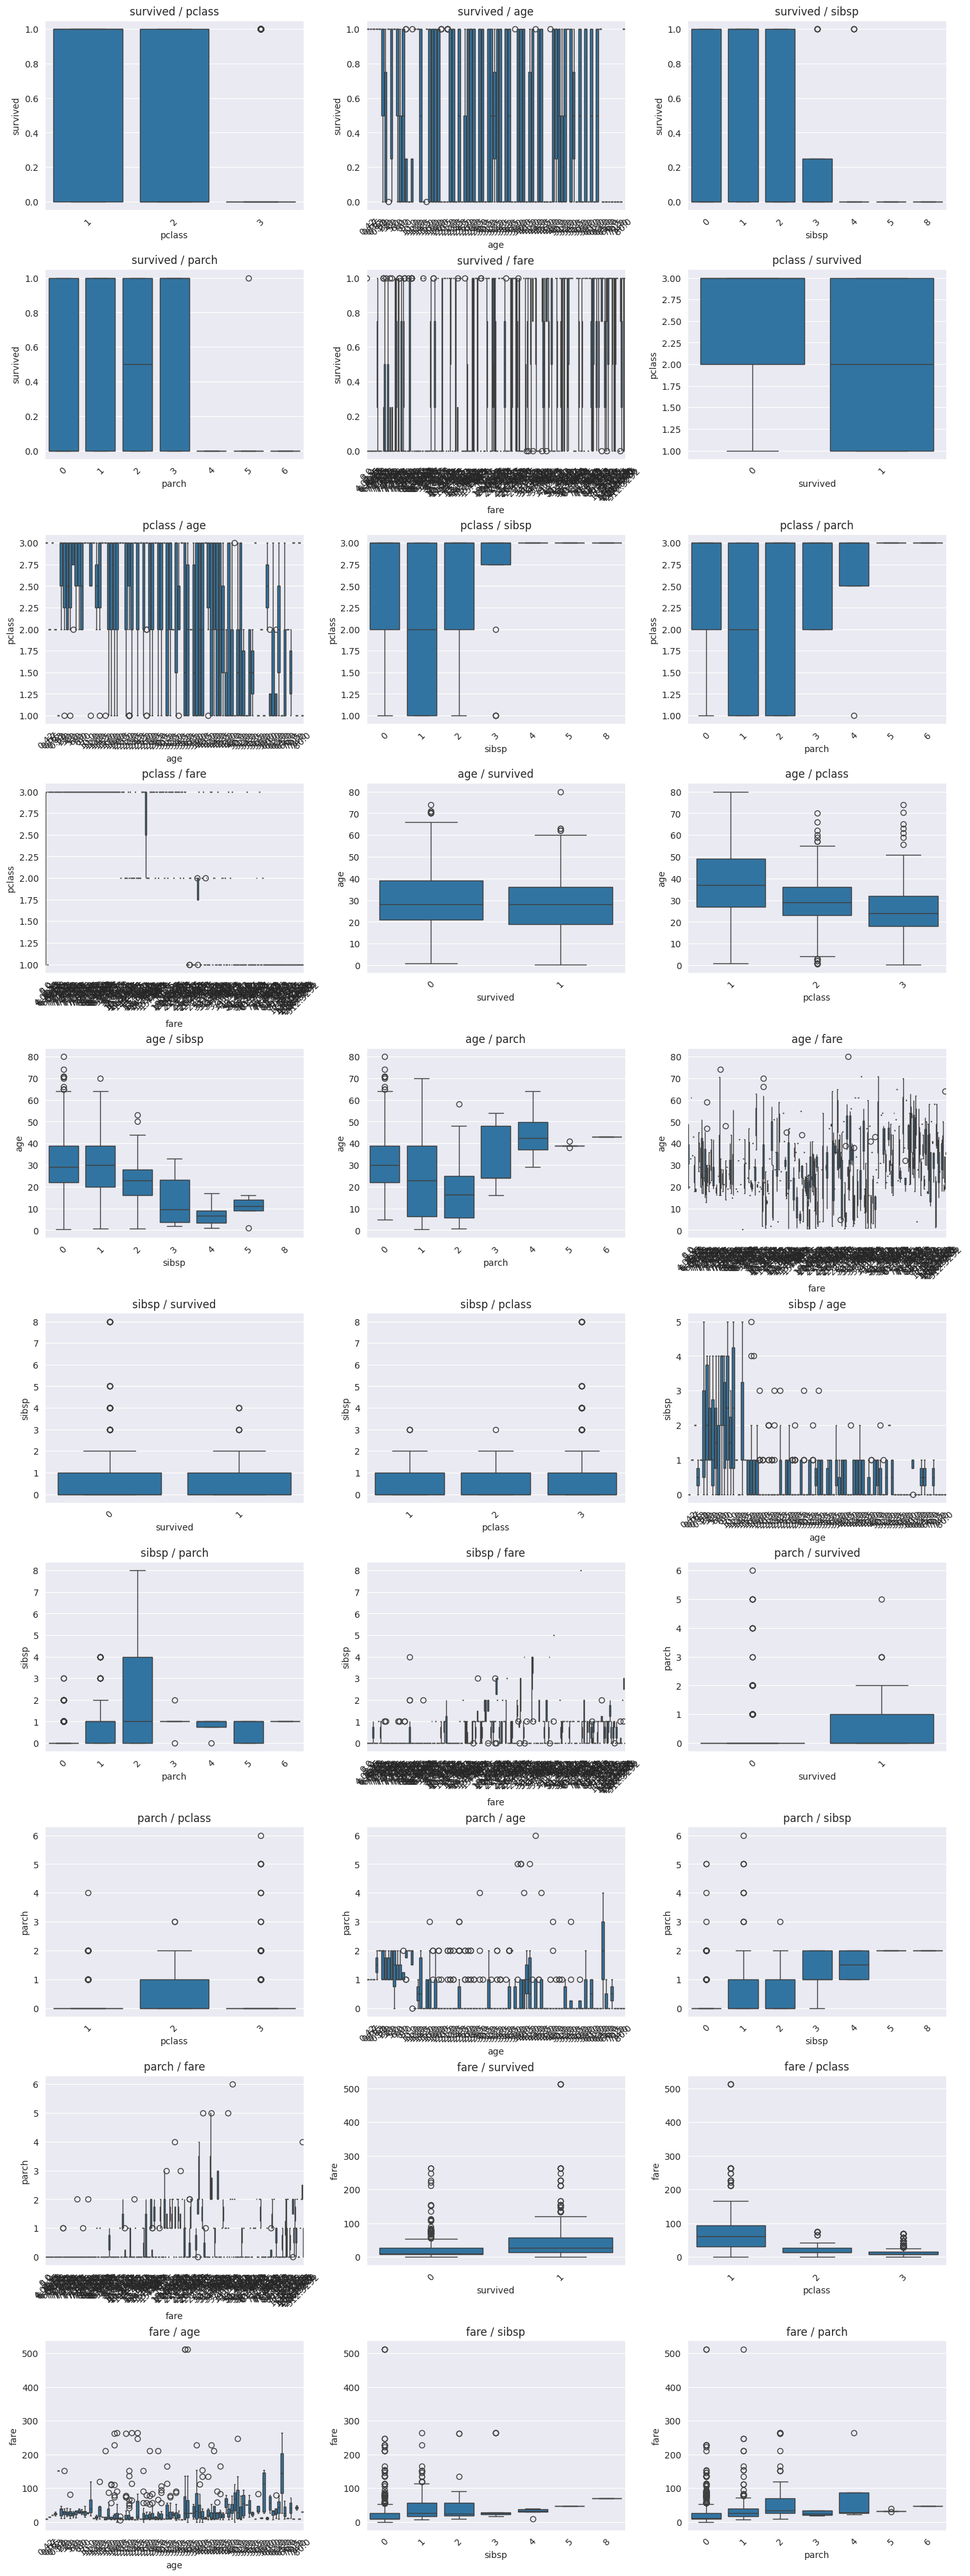

In [12]:
var = df.select_dtypes(include="number").columns # Liste contenant les variables numériques uniquement
var = list(itertools.permutations(var,2)) # Permutation des covariables tel que var1 != var2
cols = 3
rows = math.ceil(len(var) / cols) 

fig, axes = plt.subplots(
    rows,
    cols,
    figsize = (5*cols, 4*rows),
    constrained_layout=True
)
axes = axes.flatten()

for i, (var1, var2) in enumerate(var): # Boites à moustache
    sns.boxplot(
        data = df,
        x = var2,
        y = var1,
        ax=axes[i]
    )
    axes[i].set_title(f"{var1} / {var2}")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)): # Retire les axes inutiles
    fig.delaxes(axes[j])

plt.show()

In [13]:
df.shape

(891, 15)

Les rectangles bleu sont les valeurs appartenant à l'ensemble $[q,p]$ tel que $p$ est la valeur du plus petit quartile et $q$ la valeur du plus grand quartile. Les **outliers** sont les ronds noirs, qui représentent les valeurs en dehors du regroupement des données. Ci-dessous une image qui schématise le fonctionnement d'un diagramme en boîte à moustaches (box plot) : 

![title](Pictures/BoxPlot.png)

#### 3.2 Supression des outliers 
#### IQR
On peut retirer les outliers avec la méthode de l'IQR (Interquartile Range) comme ceci :

In [14]:
df_num = df.select_dtypes(include="number") # Garde les covariables numériques uniquement

# Calcul des bornes
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1

k = 1.2 # Limite acceptable

mask = ~((df_num < (Q1 - k*IQR)) | (df_num > (Q3 + k*IQR))).any(axis=1) # Masque booléen : True si la valeur n’est pas un outlier

df = df[mask] # Application du masque

Vérifions l'effet de ce masque sur le dataset :

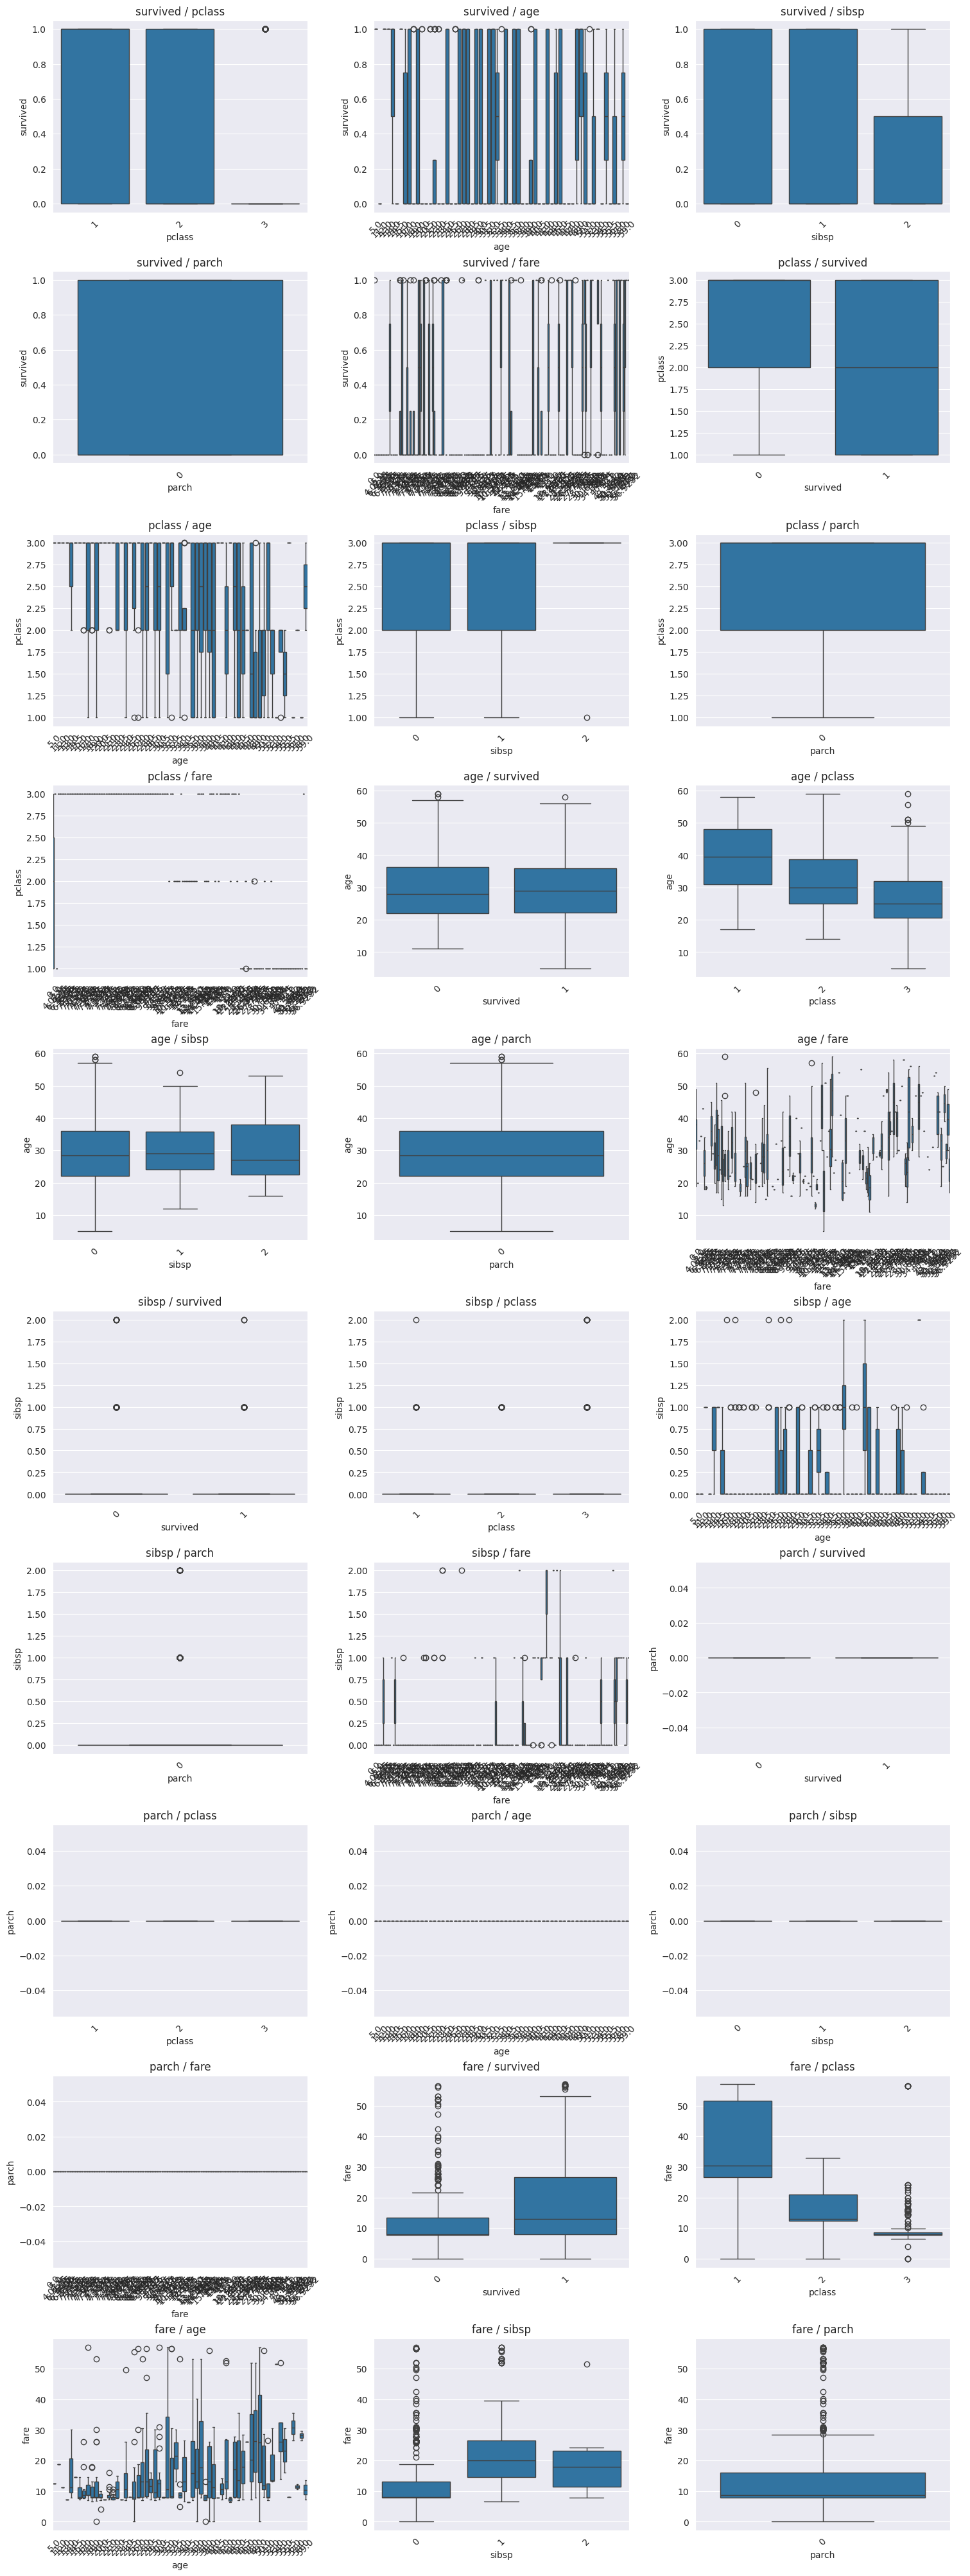

In [15]:
var = df.select_dtypes(include="number").columns # Liste contenant les variables numériques uniquement
var = list(itertools.permutations(var,2)) # Permutation des covariables tel que var1 != var2
cols = 3
rows = math.ceil(len(var) / cols) 

fig, axes = plt.subplots(
    rows,
    cols,
    figsize = (5*cols, 4*rows),
    constrained_layout=True
)
axes = axes.flatten()

for i, (var1, var2) in enumerate(var): # Boites à moustache
    sns.boxplot(
        data = df,
        x = var2,
        y = var1,
        ax=axes[i]
    )
    axes[i].set_title(f"{var1} / {var2}")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)): # Retire les axes inutiles
    fig.delaxes(axes[j])

plt.show()

In [16]:
df.shape

(587, 15)

On voit que le nombre d'outliers a diminué. D'autres outliers sont apparus car la valeur des quartiles se sont actualisés. On peu perdre plus ou moins de valeurs en fonction du $k$ que l'on prend. Il est fixé en fonction du niveau de tolérance des outliers mais aussi de la taille du dataset.

### 4. Gestion des valeurs manquantes
---
#### 4.1 Généralités

De manière générale, la gestion des valeurs manquantes se fait en fonction de la taille du dataset et de la proportion de valeurs manquantes pour une variable donnée. La méthode à effectuer pour traiter ces données manquantes découle de ces deux composantes. On peut résuler cela dans un tableau

<table style="width:100%; border-collapse: collapse; background-color: #e0f7f5; box-shadow: 0 2px 8px rgba(0, 128, 128, 0.1); font-family: sans-serif;">
  <thead>
    <tr style="background-color: #b2f0ec; color: #006666;">
      <th style="border:1px solid #91d8d4; padding:10px;">Taille du dataset</th>
      <th style="border:1px solid #91d8d4; padding:10px;">Nombre d'échantillons</th>
      <th style="border:1px solid #91d8d4; padding:10px;">Proportion de données manquantes (%)</th>
      <th style="border:1px solid #91d8d4; padding:10px;">Méthode recommandée</th>
    </tr>
  </thead>
  <tbody>
    <tr style="background-color:#f2fcfb;">
      <td style="border:1px solid #bce7e4; padding:10px;">Grand</td>
      <td style="border:1px solid #bce7e4; padding:10px;">&gt; 10 000</td>
      <td style="border:1px solid #bce7e4; padding:10px;">0% - 5%</td>
      <td style="border:1px solid #bce7e4; padding:10px;">Supression directe (<code> dropna </code>)</td>
    </tr>
    <tr style="background-color:#ffffff;">
      <td style="border:1px solid #bce7e4; padding:10px;">Grand</td>
      <td style="border:1px solid #bce7e4; padding:10px;">&gt; 10 000</td>
      <td style="border:1px solid #bce7e4; padding:10px;">5% - 15%</td>
      <td style="border:1px solid #bce7e4; padding:10px;">Imputation simple (moyenne, médiane, mode)</td>
    </tr>
    <tr style="background-color:#f2fcfb;">
      <td style="border:1px solid #bce7e4; padding:10px;">Grand</td>
      <td style="border:1px solid #bce7e4; padding:10px;">&gt; 10 000</td>
      <td style="border:1px solid #bce7e4; padding:10px;">15% - 30%</td>
      <td style="border:1px solid #bce7e4; padding:10px;">Imputation avancée (KNN, modélisation)</td>
    </tr>
    <tr style="background-color:#ffffff;">
      <td style="border:1px solid #bce7e4; padding:10px;">Grand</td>
      <td style="border:1px solid #bce7e4; padding:10px;">&gt; 10 000</td>
      <td style="border:1px solid #bce7e4; padding:10px;">&gt; 30%</td>
      <td style="border:1px solid #bce7e4; padding:10px;">Réflexion : supprimer colonnes ou imputation lourde</td>
    </tr>
    <tr style="background-color:#f2fcfb;">
      <td style="border:1px solid #bce7e4; padding:10px;">Moyen</td>
      <td style="border:1px solid #bce7e4; padding:10px;">1000 - 10 000</td>
      <td style="border:1px solid #bce7e4; padding:10px;">0% - 5%</td>
      <td style="border:1px solid #bce7e4; padding:10px;">Suppression directe</td>
    </tr>
    <tr style="background-color:#ffffff;">
      <td style="border:1px solid #bce7e4; padding:10px;">Moyen</td>
      <td style="border:1px solid #bce7e4; padding:10px;">1000 - 10 000</td>
      <td style="border:1px solid #bce7e4; padding:10px;">5% - 15%</td>
      <td style="border:1px solid #bce7e4; padding:10px;">Imputation simple (moyenne/médiane)</td>
    </tr>
    <tr style="background-color:#f2fcfb;">
      <td style="border:1px solid #bce7e4; padding:10px;">Moyen</td>
      <td style="border:1px solid #bce7e4; padding:10px;">1000 - 10 000</td>
      <td style="border:1px solid #bce7e4; padding:10px;">15% - 30%</td>
      <td style="border:1px solid #bce7e4; padding:10px;">Imputation avancée + attention au biais</td>
    </tr>
    <tr style="background-color:#ffffff;">
      <td style="border:1px solid #bce7e4; padding:10px;">Moyen</td>
      <td style="border:1px solid #bce7e4; padding:10px;">1000 - 10 000</td>
      <td style="border:1px solid #bce7e4; padding:10px;">&gt; 30%</td>
      <td style="border:1px solid #bce7e4; padding:10px;">Supprimer colonnes très vides, imputation partielle</td>
    </tr>
    <tr style="background-color:#f2fcfb;">
      <td style="border:1px solid #bce7e4; padding:10px;">Petit</td>
      <td style="border:1px solid #bce7e4; padding:10px;">&lt; 1 000</td>
      <td style="border:1px solid #bce7e4; padding:10px;">0% - 5%</td>
      <td style="border:1px solid #bce7e4; padding:10px;">Suppression directe</td>
    </tr>
    <tr style="background-color:#ffffff;">
      <td style="border:1px solid #bce7e4; padding:10px;">Petit</td>
      <td style="border:1px solid #bce7e4; padding:10px;">&lt; 1000</td>
      <td style="border:1px solid #bce7e4; padding:10px;">5% - 15%</td>
      <td style="border:1px solid #bce7e4; padding:10px;">Imputation simple ou pondérée</td>
    </tr>
    <tr style="background-color:#f2fcfb;">
      <td style="border:1px solid #bce7e4; padding:10px;">Petit</td>
      <td style="border:1px solid #bce7e4; padding:10px;">&lt; 1000</td>
      <td style="border:1px solid #bce7e4; padding:10px;">15% - 30%</td>
      <td style="border:1px solid #bce7e4; padding:10px;">Imputation prudente, modèles plus robustes</td>
    </tr>
    <tr style="background-color:#ffffff;">
      <td style="border:1px solid #bce7e4; padding:10px;">Petit</td>
      <td style="border:1px solid #bce7e4; padding:10px;">&lt; 1000</td>
      <td style="border:1px solid #bce7e4; padding:10px;">&gt; 30%</td>
      <td style="border:1px solid #bce7e4; padding:10px;">Danger : acquisition de données supplémentaires</td>
    </tr>
  </tbody>
</table>

#### 4.2 Déterminer le nombre d'échantillons

In [17]:
df = pd.read_csv( # Import du dataset
    'src/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

df.shape[0]

1464

#### 4.3 Déterminer la proportion de valeurs manquantes

In [18]:
missing_percentage = df.isna().mean() * 100
print("MISSING VALUES :")
if missing_percentage[missing_percentage != 0].empty:
    print("No")
else:
    print(missing_percentage[missing_percentage != 0].sort_values(ascending=False))

MISSING VALUES :
maxO3     4.986339
maxO3v    4.986339
Ne18      0.341530
Ne9       0.136612
Ne12      0.136612
Ne6       0.136612
Ne15      0.136612
T18       0.068306
T15       0.068306
T12       0.068306
T9        0.068306
T6        0.068306
Vdir6     0.068306
Vdir9     0.068306
Vvit6     0.068306
Vvit9     0.068306
Vdir12    0.068306
Vdir15    0.068306
Vvit12    0.068306
Vvit15    0.068306
Vdir18    0.068306
Vvit18    0.068306
Vx        0.068306
dtype: float64


#### 4.4 Méthodes d'imputation et de suppression directe

Une fois la taille du dataset et le nombre d'échantillons incomplets trouvés, plusieurs méthodes sont proposées pour soit compléter le dataset soit supprimer les lignes. Pour le choix de la méthode, se référer à la partie **4.1**.

#### 4.4.1 Suppression directe

Pour un dataset de grande taille et/ou avec peu de données incomplètes, on préconise de supprimer les lignes car l'influence de la perte d'information de ces lignes est négligeable.

In [19]:
df = pd.read_csv( # Import du dataset
    'src/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

df.dropna(inplace=True) # Supression directe

Si une colonne contient trop peu d'informations, on peut aussi décider de ne pas la prendre en compte. Dans ce cas, on diminue le nombre de variables disponibles.

In [20]:
df = pd.read_csv( # Import du dataset
    'src/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

df = df.drop("T6", axis=1) # Suppression d'une covariable (T6)

In [21]:
df = pd.read_csv( # Import du dataset
    'src/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

df = df.drop([
    "T6",
    "T9",
    "T15",
    "Ne6"
    ], axis=1) # Suppression de plusieurs covariables (T6, T9, T15, Ne6)

#### 4.4.2 Imputation simple

Si le dataset contient une proportion non négligeable mais modérée d'informations manquantes, on peu compléter le dataset en utilisant des méthodes classiques d'imputation comme remplacer les valeurs par la moyenne ou la médiane de sa covariable.

#### Imputation par la moyenne

In [22]:
df = pd.read_csv( # Import du dataset
    'src/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

df = df.fillna(df.mean()) # Imputation simple par la moyenne

#### Imputation par la médiane

In [23]:
df = pd.read_csv( # Import du dataset
    'src/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

df = df.fillna(df.median()) # Imputation simple par la médiane

**Attention**, cette méthode marche uniquement pour les données numériques. Pour les classes, il faut utiliser scikit-learn. 

In [24]:
df = pd.read_csv( # Import du dataset
    'src/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

imputer = SimpleImputer(strategy='mean')  # Initialisation de l'imputeur par la moyenne
df = imputer.fit_transform(df)  # Applique l'imputation

In [25]:
df = pd.read_csv( # Import du dataset
    'src/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

imputer = SimpleImputer(strategy='median')  # Initialisation de l'imputeur par la médiane
df = imputer.fit_transform(df)  # Applique l'imputation

#### 4.4.3 Imputation avancée
#### KNN

L'imputation KNN est basé sur l'algorithme du plus proche voisin : l'algorithme va regarder les $k$ voisins les plus proches de la valeur manquante (par exemple, pour $k=2$, numéro de ligne incomplète : 50, les lignes 49 et 51 vont êtres lues) puis va faire la moyenne ou la médiane de ces valeurs (à choisir en fonction de la stratégie). Un exmeple avec un $k = 5$

In [26]:
df = pd.read_csv( # Import du dataset
    'src/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

imputer = KNNImputer(n_neighbors=5) # Initialisation de l'imputeur KNN
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns) # Application de l'imputeur

#### MICE

In [27]:
df = pd.read_csv( # Import du dataset
    'src/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

imputer = IterativeImputer(max_iter=100, random_state=0) # Initialisation de l'imputeur MICE
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns) # Application de l'imputeur

#### Régression

In [28]:
df = pd.DataFrame({ # Import du dataset fictif
    'age': [25, 30, 35, 40, np.nan, 50, 55, np.nan],
    'salaire': [2000, 2500, 2700, 3000, 3200, 3500, 3700, 3900]
})

# Séparation des lignes avec et sans valeur manquante
df_complete = df[df['age'].notna()]
df_missing = df[df['age'].isna()]

# Régression : prédire 'age' à partir de 'salaire'
X_train = df_complete[['salaire']]
y_train = df_complete['age']

reg = LinearRegression()
reg.fit(X_train, y_train)

# Prédiction des valeurs manquantes
X_missing = df_missing[['salaire']]
df.loc[df['age'].isna(), 'age'] = reg.predict(X_missing)

#### 4.4.4 Pour aller encore plus loin
Ce type d'imputation est très performante. Cela dit, dérouler ces algorithmes nécéssite une grande puissance de calcul. 
#### Autoencoders

#### 4.5 Exemple concrès
Ici, on cherche à avoir un dataset qui se prête à l"exercice. Autrement dit, on veut un jeu de données qui ne soit pas déjà nettoyé ou assez propre et exploitable comme pourrait l'être le dataset sur le Titanic ou les fleurs d'Iris. Pour cela, on reprend le dataset `ozone_complet.csv`, un dataset plus tumultueux que les autres comme le démontre le script suivant :

In [29]:
df = pd.read_csv( # Import du dataset
    'src/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

missing_percentage = df.isna().mean() * 100
print("MISSING VALUES :")
if missing_percentage[missing_percentage != 0].empty:
    print("No")
else:
    print(missing_percentage[missing_percentage != 0].sort_values(ascending=False))

MISSING VALUES :
maxO3     4.986339
maxO3v    4.986339
Ne18      0.341530
Ne9       0.136612
Ne12      0.136612
Ne6       0.136612
Ne15      0.136612
T18       0.068306
T15       0.068306
T12       0.068306
T9        0.068306
T6        0.068306
Vdir6     0.068306
Vdir9     0.068306
Vvit6     0.068306
Vvit9     0.068306
Vdir12    0.068306
Vdir15    0.068306
Vvit12    0.068306
Vvit15    0.068306
Vdir18    0.068306
Vvit18    0.068306
Vx        0.068306
dtype: float64


On décide de remplacer chaque valeurs manquantes par la médiane donnée par la covariable. **Attention** : cette méthode marche uniquement pour des valeurs numériques, il faut donc faire un tri dans les covariables pour retirer les classes.

In [30]:
df.fillna(df.median(numeric_only=True)) # Remplace uniquement les valeurs numériques

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
date,,,,,,,,,,,,,,,,,,,,,
19950401,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,290.0,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2
19950402,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,160.0,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6
19950403,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,20.0,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2
19950404,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,10.0,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8
19950405,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,340.0,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20020926,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,7.0,...,290.0,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000,79.0
20020927,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,6.0,...,70.0,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660,76.0
20020928,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,2.0,...,120.0,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641,79.0


On peut aussi décider de supprimer tous les échantillons incomplets, c'est à dire ceux dont il manque une valeur à au moins une des variables pour chaque lignes.

In [31]:
df.dropna(inplace=True) # Retire les lignes qui ont des valeurs manquantes
df

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
date,,,,,,,,,,,,,,,,,,,,,
19950401,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,290.0,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2
19950402,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,160.0,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6
19950403,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,20.0,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2
19950404,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,10.0,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8
19950405,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,340.0,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20020926,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,7.0,...,290.0,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000,79.0
20020927,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,6.0,...,70.0,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660,76.0
20020928,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,2.0,...,120.0,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641,79.0


### 4. Gestion des variables
---
#### 4.1 Séparation des variables dépendantes et explicatives

In [32]:
df = sns.load_dataset("titanic") # Charge le dataset

target = 'survived' # Variable dépendante

y = df[target]
X = df.drop(target, axis=1)

In [33]:
X

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [34]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: survived, Length: 891, dtype: int64

*A priori*, toutes les variables sont potentiellement des covariables. Reste à les trier en fonction de leurs degrés de pertinence que l'on mesure grâce aux **métriques**. Il existe plusieurs algorithmes de tri de covariables comme le stepwise.

#### 4.2 Séparation des variables de test et de train

On sépare les données de test et d'entraînement pour connaître la fiabilité du modèle. L'idée est de séparer le datset initial en deux parties (datasets) distinctes grâce à la méthode train\_test\_split. Les arguments de la méthode sont :

1. test\_size : proportion (%) des données de test. Par exemple, si test\_size = 0.2, la méthode va prendre 20% des données comme étant du test et les 80% restants seront alloués à l'entraînement du modèle.
2. random\_state : c'est la seed de notre modèle. Cet argument permet de le sauvegarder et de le rendre unique pour pouvoir le réutiliser plus loin dans le code.

L'intérêt de cette méthode est de pouvoir observer le comportement du modèle sur un dataset qu'il ne connaît pas afin de calculer son ELMQ. 

1. Import des données

On génère un dataset artificiel afin de montrer graphiquement ce que la séparation entre les données de test et de train veut dire.

In [35]:
# Init
sns.set_style("darkgrid") # Style du graphe
N = 1000

# Init X et Y (Y = 2*X + 3 + bruit)
X = np.array([
   np.random.normal(0,1) for _ in range(N)
]).reshape(-1,1)
Y = 2*X + 3 + np.array([
   np.random.normal(0,1) for _ in range(N)
]).reshape(-1,1)

# Visualisation du dataset
df = pd.DataFrame({
    "Y" : Y.reshape(-1),
    "X" : X.reshape(-1)
})
df.head()

,Y,X
0,2.555827,-0.457013
1,7.886247,2.156191
2,3.386378,-0.153443
3,4.172940,0.411161
4,1.770303,-0.149122


Séparation des données train et test :

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

Visualisation des données :

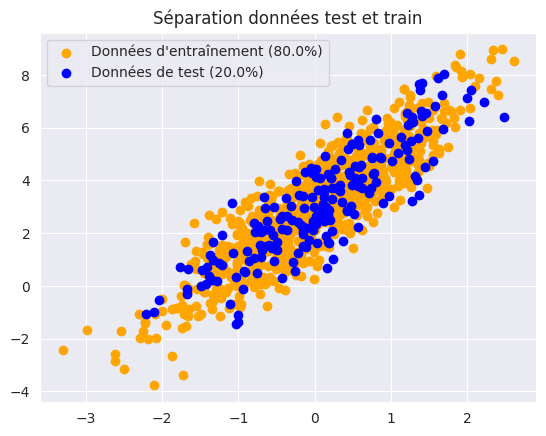

In [37]:
# Visualisation des données
plt.scatter(X_train,Y_train, label=f"Données d'entraînement ({X_train.shape[0]*100/X.shape[0]}%)", color="Orange")
plt.scatter(X_test,Y_test, label = f"Données de test ({X_test.shape[0]*100/X.shape[0]}%)", color="Blue")
plt.legend()
plt.title("Séparation données test et train")
plt.show()

Ici, on peut voir la répartition des données de test (bleu) et de train (orange). Si les données sont encore trop bruitées, on peut alors songer à appliquer un **filtrage** sur les données.

### 5. Filtrage
---

### Définition générale d'un filtre

Un filtre est une fonction $h$ de l'espace des vers

### Les différentes familles de filtre

1. Filtres linéaires
    
    1. Filtre moyenneur
    2. Filtre de Wiener

2. Filtres non-linéaires

    1. Filtre médian 
    2. Filtre bilatéral

3. Filtres fréquentiels

    1. Filtres passe bas, passe haut, passe bande...
    2. Transformée en ondeltettes

4. Filtres bayésiens

    1. Filtre de Kalman
    2. Filtre particulaire

### Filtre moyenneur
#### Signal simulé :

On modélise un signal sinusoïdal bruité

### Filtre de Wiener
#### Signal simulé :

On modélise un signal sinusoïdal bruité

## III Identification des relations entre les différentes variables

### 1. Modélisation du *dataset* 
---
La bonne pratique est maintenant de trouver des relations (linéaires ou non) entre les différentes variables (colonnes). On peut voir en un coup d'oeil les différentes relations entre les variables grâce à des nuages de points Par la suite, on essayera de quantifier la "taux" de relation entre les différentes variables à l'aide d'une matrice de corrélation. L'idée est la suivante : 

1. Notre **dataset** $D$ est constitué de 5 colonnes de 150 lignes, soit 5 variables de 150 échantillons chacun. Prenons $p = 5$ et $n = 150$. Le *dataset* se modélise alors comme une matrice $D \in \mathcal{M}_{n,p}(\mathbb{R})$. Les éléments $(a_{i,j})_{i,j \in ⟦1; n⟧ \times ⟦1; p⟧} \in D$ sont les valeurs correspondants à la $i$-ème ligne et la $j$-ième colonne.

2. Un **nuage de points** est un ensemble $M_{i,j} = \{m_{k} | m_{k} = (x_{k},y_{k}), k \in ⟦1; n⟧\}$ tels que :

    1. $x_{k}$ est le $k$-ème échantillon de la colonne $i$
    2. $x_{k}$ est le $k$-ème échantillon de la colonne $j$

    $$
    $$
3. On définit la **matrice de nuages de points** $M \in \mathcal{M}_{p}(\mathbb{R})$ tel que :

    $$ M = 
    \begin{bmatrix}
    M_{1,1} & \dots & M_{1,p}\\
    \vdots & M_{i,j} & \vdots \\
    M_{n,1} & \dots & M_{n,p}\\
    \end{bmatrix}
    $$

    1. Les $(M_{i,j})_{i,j \in \mathcal C}$ sont les éléments de $M$, soit les nuages de points formés par les variables du *dataset*.
    2. L'ensemble $\mathcal C$ désigne l'image du produit cartésien entre l'ensemble des numéros de colonne ⟦1; n⟧, i.e :
    $$
    \mathcal C = Im(⟦1; n⟧ \times ⟦1; n⟧)
    $$

   3. Remarque : par définition, $M$ est symétrique. Pour des raisons d'optimisation du temps de calcul, on peut alors uniquement calculer les éléments $(M_{i,j})_{i,j \in \mathcal C}$ pour la diagonale supérieure ou inférieure et en déduire le reste des éléments de matrice

Intuitivement, $M_{i,j}$ est l'ensemble de points de coordonnées $(x_{k},y_{k})$ entre deux colonnes $i$ et $j$ du *dataset*. $k$ est le numéro de l'échantillon observé. 

### 2. Matrice de nuages de points
---
En Python, on utilise la méthode `pairplot` de la librairie `seaborn` pour tracer la matrice de nuages de points. L'argument `hue` permet de séparer les variables en fonction d'un type, d'une colonne. Ici, on sépare les points par espèces d'iris.

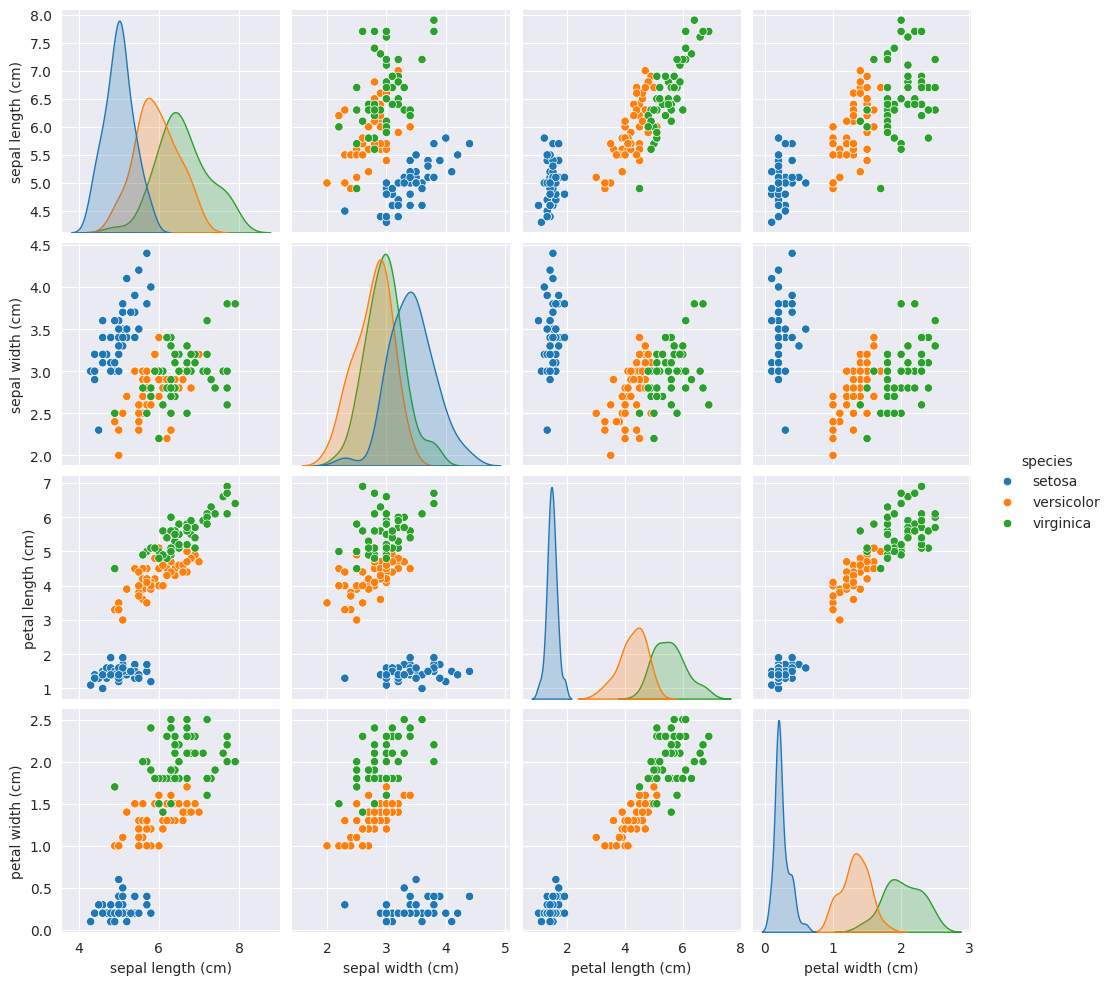

In [38]:
iris = load_iris() # Charge le dataset
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)


# Charge les espèces des iris et change le nom des colonnes dans le DataFrame 
df["species"] = iris.target
species_names = iris.target_names
df['species'] = df['species'].apply(lambda x: species_names[x])

sns.pairplot(df, hue="species") # Séparation par espèces
plt.show()

### Interprétation

On remarque à première vue qu'il existe une relation linéaire entre la longueur et la largeur des pétals pour les iris de type versicolor et virginica, ce qui n'est pas le cas pour la setosa par exemple. D'autres relations existent. De plus, le taux d'acroissement entre les relations linéaires de chaque variables semble changer en fonction de l'espèce. On veillera par conséquent à séparer les epèces par la suite. 
<br>


### 3. Matrice de corrélation
---

Pour aller plus loin dans l'interprétation des données, on va maintenant afficher la matrice de corrélation du *dataset*. Une telle matrice $R$ est représentée comme suit :

$$ R = 
\begin{bmatrix}
    R_{1,1} & \dots & R_{1,p}\\
    \vdots & R_{i,j} & \vdots \\
    R_{n,1} & \dots & R_{n,p}\\
\end{bmatrix}
$$

Avec les $(R_{i,j})_{i,j \in \mathcal C}$ éléments de $R$, coefficients de corrélation pour chaque nuages de points. En fonction du type de relation (linéaire, quadratique, monotone...), que l'on veut détecter, différentes méthodes peuvent êtres approchées. Prenons deux variables (ou colonnes) $X$ et $Y$ :

#### 1. Pour les **relations linéaires**, on utilise la méthode de **Pearson** à l'aide de la formule suivante :

$$
R_{X,Y} = \frac{Cov(X,Y)}{\sigma_{X}\sigma_{Y}}
$$

Intuitivement, cette matrice représente, pour chaque nuages de points, une mesure du taux de corrélation entre les deux variables $x$ et $y$. La détection à l'aide de cette méthode ne concerne que les relations linéaires. Il peut en effet exster d'autres types de relations (quadratique, exponentielle, sinusoïdale...). En python, on peut utiliser la matrice de corrélation avec `pywedge`, mais le mieux reste `seaborn` qui laisse plus de crédit d'action quand aux coefficients de corrélation utilisés.

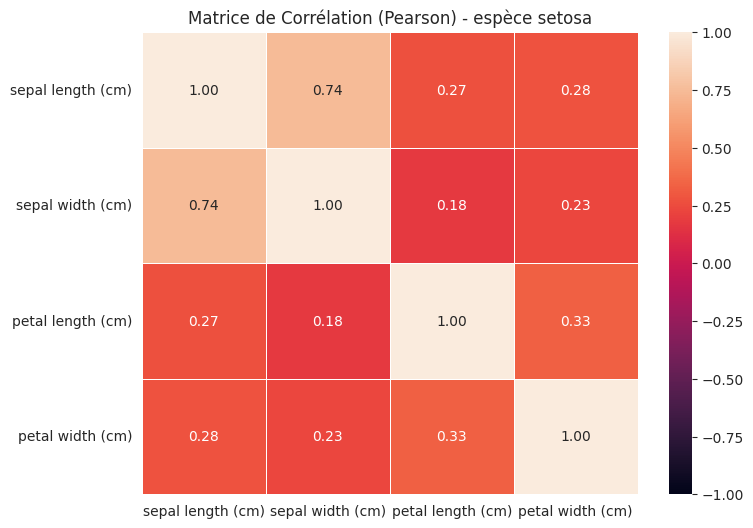

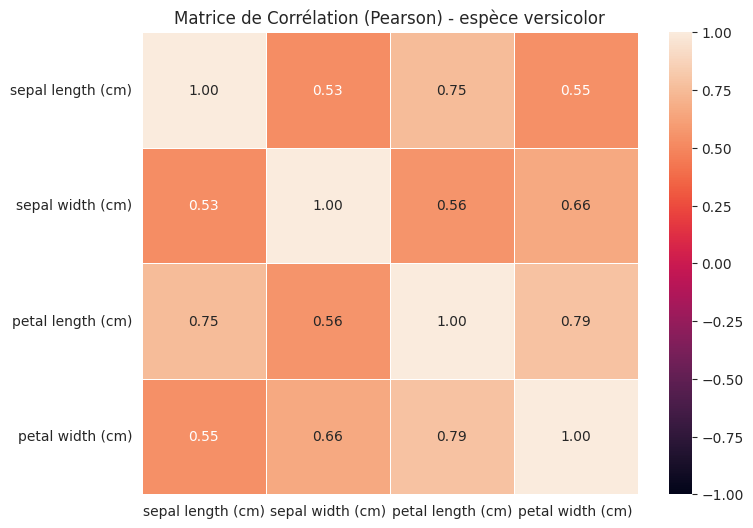

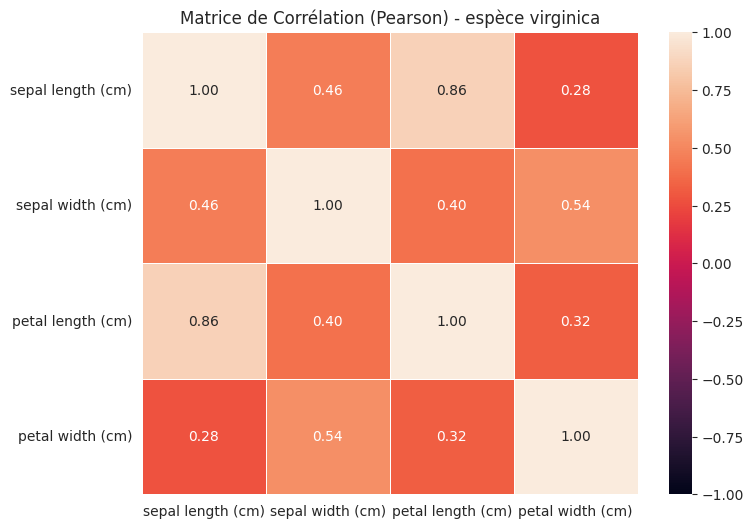

In [39]:
grouped = {name: group for name, group in df.groupby("species")} # Séparation par espèses

for key in grouped.keys(): 
    grouped[key] = grouped[key].drop(columns=["species"]) # Retire les colonnes non numériques
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        grouped[key].corr(method='pearson'), # Méthode de Pearson
        annot=True,
        linewidth=.5,
        #cmap='coolwarm',
        fmt=".2f", vmin=-1,
        vmax=1
    )
    plt.title(f"Matrice de Corrélation (Pearson) - espèce {key}")
    plt.show()

2. Pour les relations **non-linéaires** et **monotones**, on utilise la méthode de **Spearman** ou le **Tau de Kendall**. On utilise ici la méthode de **Spearman** :
   


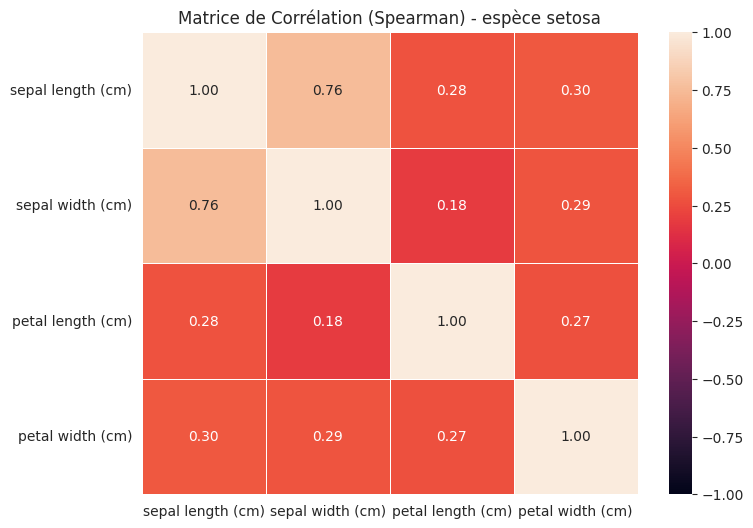

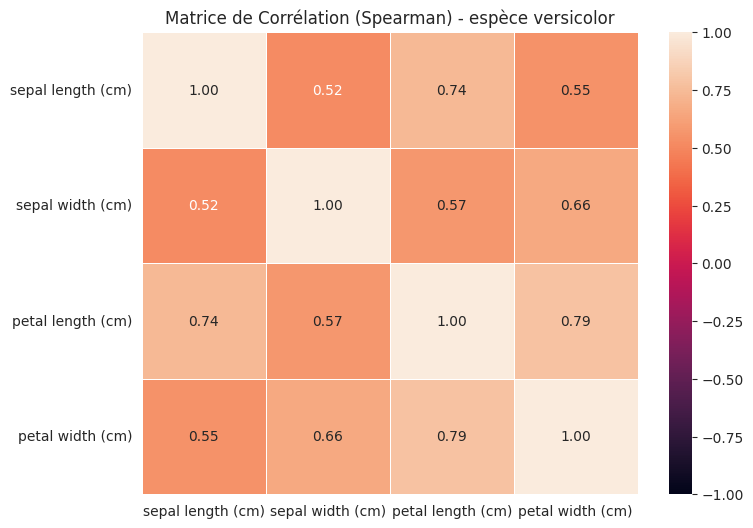

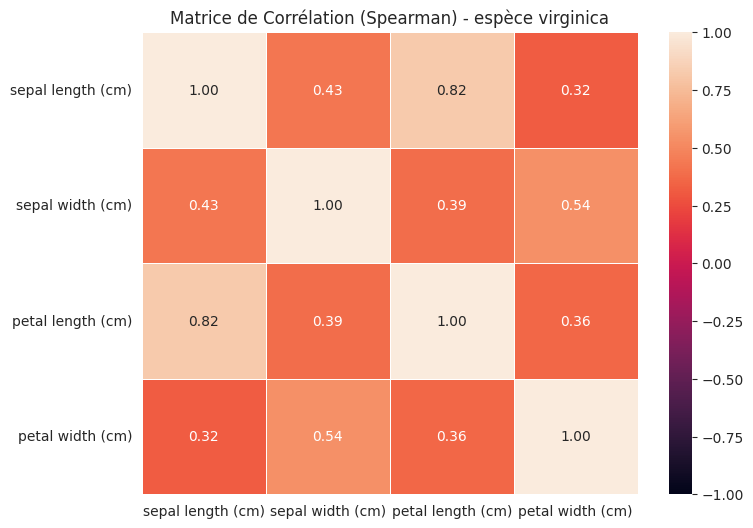

In [40]:
grouped = {name: group for name, group in df.groupby("species")} # Séparation par espèses

for key in grouped.keys(): 
    grouped[key] = grouped[key].drop(columns=["species"]) # Retire les colonnes non numériques
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        grouped[key].corr(method='spearman'), # Méthode de Spearman
        annot=True,
        linewidth=.5,
        #cmap='coolwarm',
        fmt=".2f", vmin=-1,
        vmax=1
    )
    plt.title(f"Matrice de Corrélation (Spearman) - espèce {key}")
    plt.show()

#### 3. Pour les relations **non linéaires** et **non monotones**, on utilise plutôt des méthodes telles que le **distance correlation** (dCorr) ou le **critère d'indépendance de Hilbert Schmidt** (HSIC).

##### 3.1 Distance correlation

Soient $X$ et $Y$ qui forment un dataset $(X,Y)$ tels que $X = (x_{0}, ... ,x_{n})$ et $Y = (y_{0}, ... ,y_{n})$, les $(x_{i})_{i \in \mathbb{N}}$ et $(y_{i})_{i \in \mathbb{N}}$ peuvent êtres des réels ou des vecteurs dans $\mathbb{R}^{n}$. Les $((x_{i},y_{i}))_{i \in \mathbb{N}}$ forment des échantillons. Les matrices des distances $A$ et $B$ sont définies éléments par éléments, respectivement  $(a_{i})_{i \in \mathbb{N}}$ et $(b_{i})_{i \in \mathbb{N}}$ par les distances par pairs des variables $X$ et $Y$ tels que :

$$
a_{i,j} = || x_{i} - x_{j} || \textcolor{white}{.} \forall i, j \in \mathbb{N}
$$
$$
b_{i,j} = || y_{i} - y_{j} || \textcolor{white}{.}  \forall i, j \in \mathbb{N}
$$

La distance covariance est définie par :

$$
dCov^{2}(X,Y) = \frac{1}{n^{2}}\sum_{j=1}^{n}\sum_{i=1}^{n}a_{i,j}b_{i,j}
$$

On définit aussi la distance variance par :

$$
dVar^{2}(X) :=  dCov^{2}(X,X) = \frac{1}{n^{2}}\sum_{j=1}^{n}\sum_{i=1}^{n}a_{i,j}^{2}
$$

La distance corrélation est donc définie par :

$$
dCorr^{2}(X,Y) = \frac{dCov^{2}(X,Y)}{\sqrt{dVar^{2}(X)dVar^{2}(Y)}}
$$

Plus $dCorr^{2}$ est proche de 0, moins les deux variables ont une corrélation, plus $dCorr^{2}$ est proche de 1, plus les deux variables on une forte corrélation. Pour quel type de relation lie les deux variables, on doit passer par une visualisation graphique. Pour cela, voir la partie suivante (graphes usuels).

<img src="Pictures/dCorr.png" width="500px" style="display: block; margin: 1em auto;" />


##### 3.2 Un exemple en Python : 

Prenons un dataset tel que $Y = sin(X)$. La relation entre les deux variables est évidente, mais les coefficients de Pearson et de Spearman ne détecterons pas cette relation car elle est ni linéaire, ni monotone.

In [41]:
# Exemple : y = sin(x)
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

# dCor attend des vecteurs 2D (n_samples, 1)
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Distance correlation
float(dcor.distance_correlation(x, y))

0.8516758344081017

3.2 Critère d'indépendance de Hilbert Schmidt

In [42]:
# Exemple : y = sin(x)
x = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
y = np.sin(x).reshape(-1, 1)

# HSIC test
hsic = Hsic()
stat, pvalue = hsic.test(x, y)
print("HSIC statistic:", stat)
print("p-value:", pvalue)

HSIC statistic: 0.7638137380439114
p-value: 1.4093807976062503e-18


### 4. Graphes usuels
---
Dans le cas ou la relation est identifiée comme non linéaire mais non monotone, il faut pouvoir visualiser la relation qui lie les deux pour savoir de quelle type de relation il s'agit. Pour les autres covariables, on peut aussi tracer les graphes entre les covariables liées pour interpréter leurs liens, expliquer des phénomènes ou même souligner leurs corrélations. L'objectif ici est de faire un focus sur une partie du dataset pour rentrer en profondeur.

Pour les graphes usuels, se référer au fichier `UsualGraphs` qui liste des framworks pour utiliser les graphes usuels.

### 5. Algorithmes de sélection automatique des variables
---
Ces modèles se basent sur l'évaluation des métriques. Pour plus de précision, voir la partie IV, 2. "Les métriques".
#### 5.1 Backward

## IV. Choix du modèle

### 1. Cartographie des modèles 
---

Il existe une multitude de modèles qui répondent à des problématiques différentes en fonction du problème et du dataset proposé. Voici une proposition de carte mentale pour déterminer quels modèles sont les plus appropriés en fonction du problèle posé :

In [43]:
sys.path.append('/home/alexis/VSCode/Jupyter-notebooks/BankModel/src')
from graph import graph

graph()

La carte des modèles est visible en cliquant sur le fichier `Model.html` après avoir retiré le commentaire sur l'appel de la focntion `graph`.

### 2. Les métriques
---
Les métriques sont un ensemble de méthodes permettant d'évaluer la performance d'un modèle C'est la mesure de la qualité prédictive d'un modèle.

#### 2.1 Métriques pour la régression
#### 2.1.1 Mean Squared Error (MSE)

La mean squared error est une mesure de la qualité d'un modèle qui évalue la distance entre la valeur estimée $\hat{y_{i}}$ et sa vraie valeur $y_{i}$ sur l'ensemble des données disponibles sur le dataset, c'est-à-dire $\forall i \in E \subset \mathbb{N}$ i.e. pour tout les éléments de $\hat{Y}$ et $Y$. La distance entre les $\hat{y_{i}}$ et $y_{i}$ est ensuite moyennée. On définit aussi la RMSE (Root Mean Squarred Error) de tel sorte que l'on ait un chiffre entre 0 et 1 plutôt qu'entre -1 et 1. Plus la $|MSE|$ ou la $RMSE$ se raproche de 0, moins la variable dépendante est expliquée par la ou les covariables. A l'inverse, plus la $|MSE|$ ou la $RMSE$ se raproche de 1, plus la variable dépendante est expliquée par la ou les covariables, ce qui veut dire qu'un **score proche ou égal à 1 indique une bonne performance du modèle**.

$$
MSE = \frac{1}{n}\sum_{i = 1}^{n}(y_{i} - \hat{y_{i}})^{2}
$$

$$
RMSE = \sqrt{\frac{1}{n}\sum_{i = 1}^{n}(y_{i} - \hat{y_{i}})^{2}}
$$

#### 2.1.2 Mean Absolute Error (MAE)

La MAE fonctionne de la même manière que la MSE mais en utilisant une norme différente. Quand la MSE utilise la norme $l_{2}$ (norme Euclidienne), la MAE utilise la norme $l_{1}$ (norme de Manhattan).

$$
MAE = \frac{1}{n}\sum_{i = 1}^{n}|y_{i} - \hat{y_{i}}|
$$

$$
RMAE = \sqrt{\frac{1}{n}\sum_{i = 1}^{n}|y_{i} - \hat{y_{i}}|}
$$

$$
MAPE = \frac{100}{n}\sum_{i = 1}^{n}\frac{|y_{i} - \hat{y_{i}}|}{y_{i}}
$$

Remarques : 
1. La MAPE (Mean Absolute Percent Error) est la MAE en pourcents
2. Cette métrique est moins sensible aux **outliers** (grosses erreurs).
3. On pourrait définir d'autres métriques à l'aide des normes $l_{p}, \forall p \in \mathbb{N}$

#### 2.1.3 Coefficient de détermination $R^{2}$
Le coefficient de détermination est une mesure de la performance d'un modèle statistique, il justifie la relation entre la variable dépendante et les variables explicatives. Il est définit par le complément à 1 du rapport entre la some des carrés des résidus et la somme des carrés de l'écart entre les valeurs et la moyenne.

$$
R^2 = 1 - \frac{\sum_{i = 1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i = 1}^{n} (y_i - \bar{y})^2}
$$

#### 2.1.4 Log-vraisemblance
Ou $\mathcal{l}(\beta)$ est la log-vraisemblance (log-likelihood) définie par :

$$
\mathcal{L}(\beta) = \log{(L({\beta}))}
$$
Avec :

$$
L(\beta) = \prod_{i=1}^{n} {\hat{p}_{i}}^{y_{i}} {(1 - \hat{p}_{i})}^{1 - y_{i}} 
$$
Soit :
$$
\mathcal{L}(\beta) = \sum_{i=1}^{n} y_{i}\log{\hat{p}_{i}} + (1 - y_{i}) \log{(1 - \hat{p}_{i})}
$$

Plus $\mathcal{L}(\beta)$ st grand, plus la valeur estimée est vraisemblable et donc plus le modèle est précis.

#### 2.2 Métriques pour la classification
#### 2.2.1 Accuracy

Pour les problèmes de classification, l'**accuracy score** est une métrique qui mesure la performance d'un modèle de classification. L'accuracy score représente le taux de prédictions correctes sur le nombre de prédictions totales faites par le modèle. Les prédictions correctes incluent les vrais positifs et les vrais négatifs. En ce sens, les mauvaises prédictions sont les faux positifs et les faux négatifs.

$$
Accuracy = \frac{P_{C}}{P_{T}}
$$

Avec : 

1. $P_{C}$ le nombre de prédictions correctes
2. $P_{T}$ le nombre de prédictions totales

En lien avec la précision : 

$$
P_{C} = VP + VN
$$
$$
P_{T} = VP + VN + FN + FP
$$

Avec :

1. $VP$ : vrais positifs
2. $VN$ : vrais négatifs
3. $FN$ : faux négatifs
4. $FP$ : faux positifs

d'ou le nombre de prédictions fausses :

$$
P_{F} = P_{T} - P{C} = FP + FN
$$ 

#### 2.2.4 Precision

La précision est une métrique semblable à l'accuracy score : c'est le taux de prédictions positives par rapport aux prédictions positives totales.

$$
Precision = \frac{VP}{VP + FP}
$$

#### 2.2.3 Recall

$$
Recall = \frac{VP}{VP + FN}
$$

#### 2.2.4 Matrice de confusion


#### 2.2.5 Courbe ROC-AUC


#### 2.2.6 F1-Score 


### 3. La validation croisée
---
La validation croisée est une autre type de méthodes pour évaluer les performances d'un modèle. 

## V Déploiement de dashboard en application web 

## VI Conclusion
### Arbre de décision général
Voici un arbre de décision qui explique de manière générale un parcours classique d'une étude de data-science :